# BSMS

In [2]:
import argparse
import torch
import os
from enum import Enum


class MODE(Enum):
    Train = 0
    Test = 1
    Global = 2


def getargs():
    parser = argparse.ArgumentParser(description='self.Args for training')
    parser.add_argument('-case', type=str, help='cylinder/aero/plate/Font')
    parser.add_argument('-data_dir', type=str, help='/data_dir/outputs_train(or valid, test)/. contains the datas')
    parser.add_argument('-dump_dir', type=str, help='/dump_dir/*method/ to store ckpts, logs, trajs etc')
    parser.add_argument('-space_dim', type=int, help='spatial dimension: 2 or 3')
    parser.add_argument('-mode', type=int, default=0, help='0) train 1) test 2) global roll')

    parser.add_argument('-n_train', type=int, default=1, help='train seq number')
    parser.add_argument('-n_valid', type=int, default=1, help='valid seq number')
    parser.add_argument('-n_test', type=int, default=1, help='test seq number')
    parser.add_argument('-time_len', type=int, default=2, help='time seq length')

    parser.add_argument('-noise_level', nargs='+', type=float, help='shuffle noise level vec')
    parser.add_argument('-noise_gamma', type=float, default=1, help='1~0, 1: no effect on output;0: output has the same noise level of noise')

    parser.add_argument('-recal_mesh', type=bool, default=False, help='force recalculate multi level mesh')
    parser.add_argument('-consist_mesh', type=int, help='same mesh for every snapshots?')
    parser.add_argument('-multi_mesh_layer', type=int, help='how many extra layer (in depth)?')
    parser.add_argument('-mp_time', type=int, default=1, help='how many time of MP')
    parser.add_argument('-hidden_dim', type=int, default=128, help='hidden dim of MLP')
    parser.add_argument('-hidden_depth', type=int, default=2, help='hidden depth of MLP')

    parser.add_argument('-num_epochs', type=int, default=20, help='epochs')
    parser.add_argument('-batch', type=int, default=1, help='batch size')
    parser.add_argument('-lr', type=float, default=1e-4, help='learning rate')
    parser.add_argument('-gamma', type=float, default=0.93, help='decary rate')

    parser.add_argument('-restart_epoch', type=int, default=-1, help='restart checkpoint epoch')

    args, _ = parser.parse_known_args()
    return args

In [3]:
args = getargs()
args.space_dim=2
args.n_train=1000
args.n_valid=100
args.n_test=100
args.time_len=600
args.noise_level=(0.02, 0.02)
args.consist_mesh=0
args.multi_mesh_layer=7
args.MP_time=1
args.num_epochs=5
args.batch=32
lr=0.0001
args.gamma=0.79432823472
args.data_dir='BSMS_GNN/data/cylinder'
args.dump_dir='../res/cylinder'
args.case = 'cylinder'
args.consist_mesh = bool(args.consist_mesh)
args.dump_dir = os.path.join('data/cylinder', 'ours')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.device = device
print(os.getcwd())

/Users/okm/MASTER/SST_GNN/code


In [8]:
from datasets import MeshCylinderDataset as dataset_class
from torch_geometric.loader import DataLoader
add_noise = False

#mdata = trainer.get_data(id = 2)
mdata = dataset_class(args.data_dir,
                      instance_id=1,
                      layer_num=args.multi_mesh_layer,
                      stride=1,
                      noise_shuffle=add_noise,
                      noise_level=args.noise_level,
                      noise_gamma=args.noise_gamma,
                      recal_mesh=args.recal_mesh,
                      consist_mesh=args.consist_mesh)
loader = DataLoader(mdata, batch_size=1, shuffle=False)


In [21]:
def _preproc_multi_infos(mdata, b_data, args):
        # process the multi-level mesh for batched data here
        # 1. if there is contact, merge multiple graphs into a big one by adding offsets (each layer)
        _, n, _ = mdata.in_feature.shape
            # no contact, then share the graph between batches
            # only need to reshape input tensor
        m_ids = mdata.m_idx
        m_gs_list = mdata.m_g
        m_gs = [torch.tensor(g, dtype=torch.long).to(args.device) for g in m_gs_list]
        # reshape
        b = b_data.edge_index.shape[1] // n
        b_data.x = b_data.x.reshape(b, n, -1).to(args.device)
        b_data.edge_index = b_data.edge_index.reshape(b, -1, n).to(args.device)
        return m_ids, m_gs, b_data

In [26]:
b_data = next(iter(loader))
print(b_data)
m_ids, m_gs, b_data = _preproc_multi_infos(mdata, b_data, args)

# m_ids holds which nodes to keep after downpooling
for i in range(len(m_ids)):
  print(f'm_ids : {len(m_ids[i])}')

# m_gs holds which edges to keep after downpooling
for i in range(len(m_gs)):
  print(f'm_gs : {m_gs[i].shape}')

print(f'b_data : {b_data}')

DataBatch(x=[1876, 5], edge_index=[2, 1876], batch=[1876], ptr=[2])
m_ids : 950
m_ids : 476
m_ids : 241
m_ids : 121
m_ids : 67
m_ids : 34
m_ids : 17
m_gs : torch.Size([2, 10788])
m_gs : torch.Size([2, 8194])
m_gs : torch.Size([2, 6044])
m_gs : torch.Size([2, 5080])
m_gs : torch.Size([2, 4484])
m_gs : torch.Size([2, 3232])
m_gs : torch.Size([2, 1122])
m_gs : torch.Size([2, 272])
b_data : DataBatch(x=[1, 1876, 5], edge_index=[1, 2, 1876], batch=[1876], ptr=[2])
1876


tensor([[  0,   0,   0,  ..., 949, 949, 949],
        [  1,   2,  29,  ..., 746, 947, 948]])


IndexError: index 530 is out of bounds for dimension 0 with size 2

# SETUP

## Multiscale Graph Neural Network

In [1]:
import torch
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
from dataprocessing.utils.normalization import normalize
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.pool import TopKPooling
from torch_geometric.nn.unpool import knn_interpolate

In [2]:

class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        in_channels: dim of node embeddings [128], out_channels: dim of edge embeddings [128]

        """

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear( 3* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear( 2* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        """
        reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size = None):
        """
        Handle the pre and post-processing of node features/embeddings,
        as well as initiates message passing by calling the propagate function.

        Note that message passing and aggregation are handled by the propagate
        function, and the update

        x has shpae [node_num , in_channels] (node embeddings)
        edge_index: [2, edge_num]
        edge_attr: [E, in_channels]

        """
        
        out, updated_edges = self.propagate(edge_index, x = x, edge_attr = edge_attr, size = size) # out has the shape of [E, out_channels]
        if x.shape[0] != out.shape[0]:
            print(f'X : {x.shape}')
            print(f'Out : {out.shape}')
        updated_nodes = torch.cat([x,out],dim=1)        # Complete the aggregation through self-aggregation

        updated_nodes = x + self.node_mlp(updated_nodes) # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        source_node: x_i has the shape of [E, in_channels]
        target_node: x_j has the shape of [E, in_channels]
        target_edge: edge_attr has the shape of [E, out_channels]

        The messages that are passed are the raw embeddings. These are not processed.
        """

        updated_edges=torch.cat([x_i, x_j, edge_attr], dim = 1) # tmp_emb has the shape of [E, 3 * in_channels]
        updated_edges=self.edge_mlp(updated_edges)+edge_attr

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        First we aggregate from neighbors (i.e., adjacent nodes) through concatenation,
        then we aggregate self message (from the edge itself). This is streamlined
        into one operation here.
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')
        return out, updated_edges

In [3]:
class MessagePassingBlock(torch.nn.Module):
    def __init__(self, hidden_dim,  args, num_layers = None, emb=False):
        super(MessagePassingBlock, self).__init__()
        if num_layers is None:
            self.num_layers = args.num_layers
        else: self.num_layers = num_layers

        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim,hidden_dim))
    
    def build_processor_model(self):
        return ProcessorLayer
    
    def forward(self, x, edge_index, edge_attr):
         # Step 1: encode node/edge features into latent node/edge embeddings
         # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x,edge_attr = self.processor[i](x,edge_index,edge_attr)
        return x, edge_index, edge_attr

class Unpool(nn.Module):
    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, h, pre_node_num, idx):
        new_h = h.new_zeros([pre_node_num, h.shape[-1]])
        new_h[idx] = h
        return new_h

In [4]:
class MessagePassingLayer(torch.nn.Module):
    def __init__(self, input_dim_node, 
                 input_dim_edge,
                 mlp_hidden_dim,
                 latent_dim,  
                 output_dim,
                 l_n,
                 args):
        super(MessagePassingLayer, self).__init__()
        """
        args: 
        input_dim_node : number of node features
        mlp_hidden_dim : dimension of mlp hidden layer
        l_n : depth of messagepassing layer
        l_d : laten dimensions
        """
        self.node_encoder = Sequential(Linear(input_dim_node , mlp_hidden_dim),
                              ReLU(),
                              Linear( mlp_hidden_dim, mlp_hidden_dim),
                              LayerNorm(mlp_hidden_dim))

        self.edge_encoder = Sequential(Linear( input_dim_edge , mlp_hidden_dim),
                              ReLU(),
                              Linear( mlp_hidden_dim, mlp_hidden_dim),
                              LayerNorm(mlp_hidden_dim)
                              )
        self.node_out_mlp = Sequential(Linear(mlp_hidden_dim, output_dim))
        self.edge_out_mlp = Sequential(Linear(mlp_hidden_dim, input_dim_edge))
        self.up_mmps = nn.ModuleList()
        self.down_mmps = nn.ModuleList()
        self.l_n = l_n
        self.pools = nn.ModuleList()
        self.bottom = MessagePassingBlock(mlp_hidden_dim, num_layers = 4, args = args)
        for i in range(self.l_n):
            self.down_mmps.append(MessagePassingBlock(mlp_hidden_dim, args))
            self.up_mmps.append(MessagePassingBlock(mlp_hidden_dim, args))
            self.pools.append(TopKPooling(mlp_hidden_dim, .5))
        self.unpool = Unpool()

    def forward(self,data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors
        """
        x, edge_index, edge_attr, pressure = data.x, data.edge_index, data.edge_attr, data.p

        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)
        
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        skip_perms = [torch.arange(len(x))]
        skip_e = [edge_index]
        skip_x = [x]
        skip_attr = [edge_attr]

        for idx, block in enumerate(self.down_mmps):
            x, edge_index, edge_attr = block(x, edge_index, edge_attr)
            x, edge_index, edge_attr, _,perm,_ = self.pools[idx](x = x, edge_index = edge_index, edge_attr = edge_attr)
            skip_x.append(x)
            skip_perms.append(perm)
            if idx != self.l_n -1:
                skip_e.append(edge_index)
                skip_attr.append(edge_attr)
        x, _, _ = self.bottom(x, edge_index, edge_attr)
        for idx, block in enumerate(self.up_mmps):
            idx = self.l_n - idx - 1
            x_idx, edge_index, edge_attr  = skip_perms.pop(), skip_e.pop(), skip_attr.pop()
            x = self.unpool(x, skip_x[idx].shape[-2], x_idx)
            x, _, _ = block(x, edge_index, edge_attr) 

        x = self.node_out_mlp(x)
        edge_attr = self.edge_out_mlp(edge_attr)
        return x, edge_index, edge_attr
    
    def loss(self, pred, inputs,mean_vec_y,std_vec_y):
        #Define the node types that we calculate loss for
        normal=torch.tensor(0)
        outflow=torch.tensor(5)

        #Get the loss mask for the nodes of the types we calculate loss for
        loss_mask=torch.logical_or((torch.argmax(inputs.x[:,2:],dim=1)==torch.tensor(0)),
                                   (torch.argmax(inputs.x[:,2:],dim=1)==torch.tensor(5)))

        #Normalize labels with dataset statistics
        labels = normalize(inputs.y,mean_vec_y,std_vec_y)

        #Find sum of square errors
        error=torch.sum((labels-pred)**2,axis=1)

        #Root and mean the errors for the nodes we calculate loss for
        loss=torch.sqrt(torch.mean(error[loss_mask]))
        
        return loss
        






# TRAIN

In [4]:
import random
import numpy as np
import torch.optim as optim
from dataprocessing.utils.normalization import get_stats
from tqdm import trange
from torch_geometric.loader import DataLoader

In [5]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model_type': 'autoencoder',  
         'num_layers': 1,
         'batch_size': 16, 
         'hidden_dim': 64, 
         'epochs': 10,
         'opt': 'adam', 
         'opt_scheduler': 'none', 
         'opt_restart': 0, 
         'weight_decay': 5e-4, 
         'lr': 0.001,
         'train_size': 100, 
         'test_size': 40, 
         'device':'cuda',
         'shuffle': True, 
         'save_velo_val': True,
         'save_best_model': False, 
         'checkpoint_dir': './best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [6]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [7]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
device = 'cpu' if torch.backends.mps.is_available() else 'cpu'
args.device = device
print(device)

True
True
cpu


In [20]:
dataset = torch.load('data/trajectories/trajectory_0.pt')[:(args.train_size+args.test_size)]
stats_list = get_stats(dataset)
input_dim_node, input_dim_edge = dataset[0].num_features, dataset[0].edge_attr.shape[1]
print(f'Input dim node: {input_dim_node}\nInput dim edge: {input_dim_edge}\nHidden dim: {args.hidden_dim}')

Input dim node: 11
Input dim edge: 3
Hidden dim: 64


In [23]:
# Define Model
model = MessagePassingLayer(input_dim_node = input_dim_node, 
                            input_dim_edge = input_dim_edge, 
                            mlp_hidden_dim = args.hidden_dim, 
                            latent_dim = args.hidden_dim,
                            l_n = 2,
                            output_dim=2,
                            args = args).to(device)
scheduler, opt = build_optimizer(args, model.parameters())

# Get Dataset Stats fro normalization
stats_list = get_stats(dataset)
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

loader = DataLoader(dataset, batch_size = 1, shuffle=args.shuffle)




In [24]:
losses = []
for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        num_loops=0
        for batch in loader:
            #Note that normalization must be done before it's called. The unnormalized
            #data needs to be preserved in order to correctly calculate the loss
            batch=batch.to(device)
            opt.zero_grad()         #zero gradients each time
            pred, e_idx, e_attr = model(batch,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            loss = model.loss(pred,batch,mean_vec_y,std_vec_y)
            loss.backward()         #backpropagate loss
            opt.step()
            total_loss += loss.item()
            num_loops+=1
        total_loss /= num_loops
        losses.append(total_loss)

Training:   0%|          | 0/10 [00:01<?, ?Epochs/s]

X : torch.Size([469, 64])
Out : torch.Size([468, 64])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 469 but got size 468 for tensor number 1 in the list.

# PLOTS


In [2]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
from torch_geometric.nn import GAE, VGAE, GCNConv
import copy
from torch import tensor
from torch_geometric.loader import DataLoader
from torchmetrics import Accuracy, AveragePrecision, Dice


tensor([[ 0.0779,  0.0000],
        [ 0.0394,  0.0000],
        [ 0.0797, -0.0012],
        ...,
        [ 0.0000,  0.0000],
        [ 0.0481, -0.0059],
        [ 0.0000,  0.0000]])
tensor([[ 0.5235,  0.0204],
        [ 0.4953,  0.0437],
        [-0.0935, -0.0593],
        ...,
        [-0.1523,  0.0395],
        [-0.1693, -0.0343],
        [-0.1128, -0.0198]])


## Make Predictions

threshold 0.0037333333333333333


/opt/homebrew/Caskroom/miniforge/base/envs/master/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


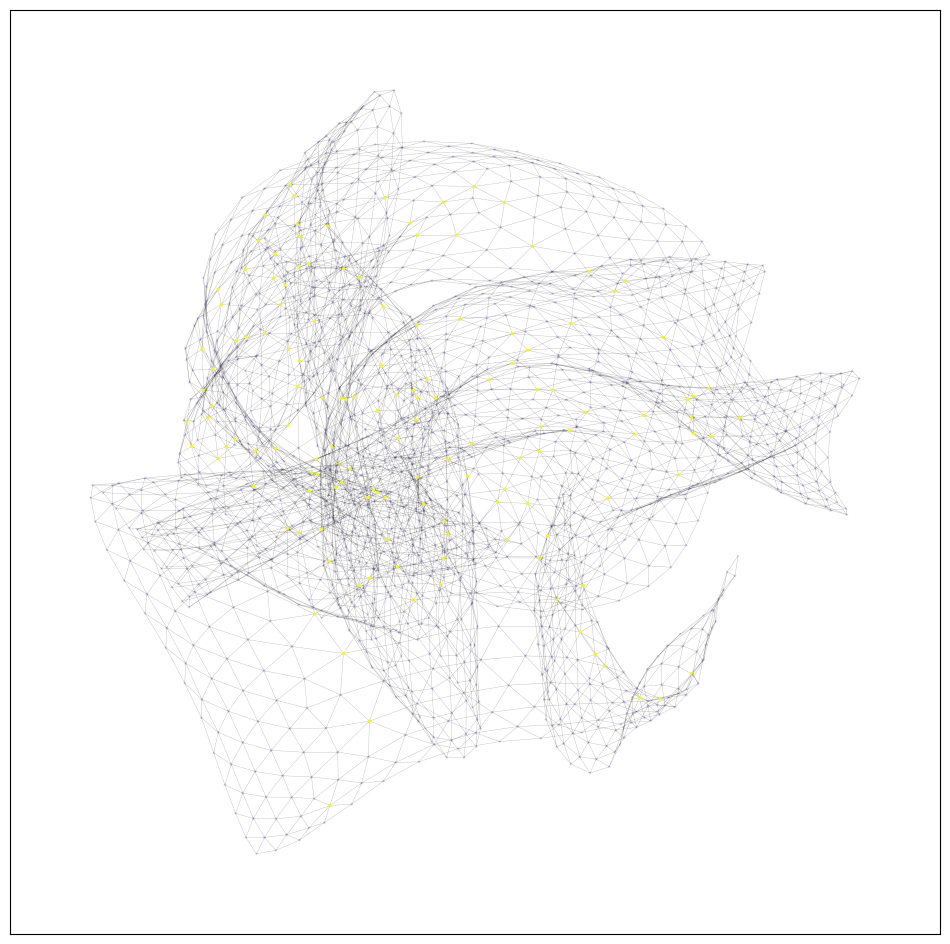

In [9]:
G = to_networkx(dataset[0], to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

In [11]:
print(dataset[0].edge_index)

tensor([[   1,    3,    5,  ..., 1618, 1872, 1475],
        [   0,    0,    3,  ..., 1620, 1873, 1872]])


140
Generating velocity fields...
140


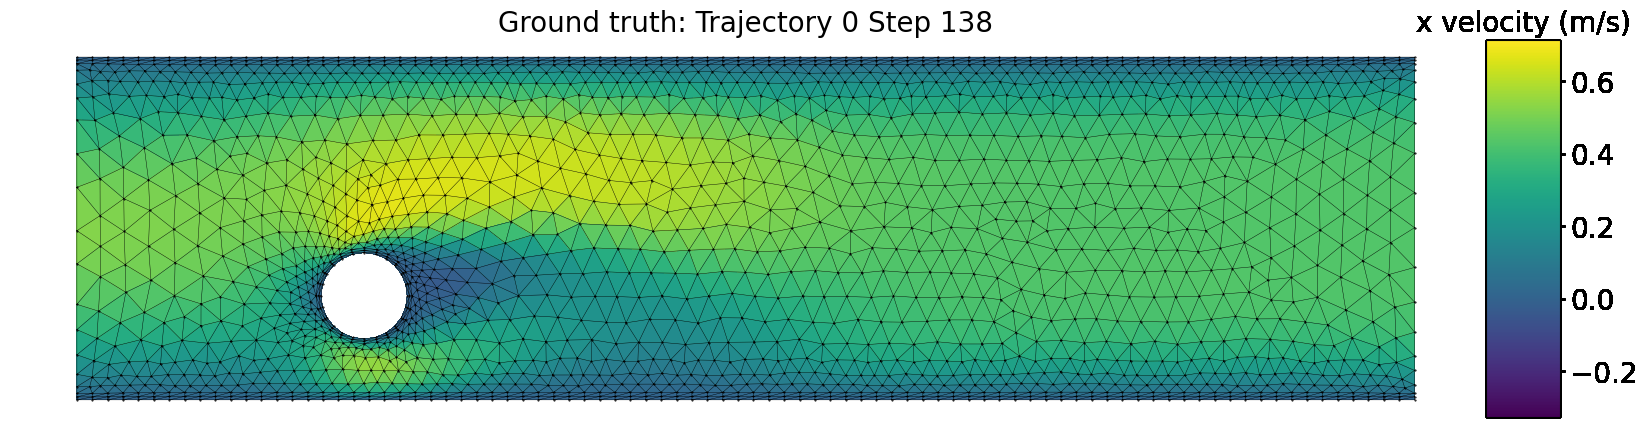

In [21]:
from utils.visualization import make_animation
loader = DataLoader(dataset, batch_size = 1)
print(len(loader))
make_animation(dataset, 'delete_me', '', save_anim=True, plot_variables=False)

In [ ]:
import pickle